In [ ]:
import torch
from torchvision import datasets, transforms, models

import os
import cv2
import glob
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import drive


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

#Dataset Initialization and Preprocessing

In [ ]:
drive.mount('/content/drive') #connect to Google Drive

Mounted at /content/drive


In [ ]:
#unzip the dataset
!unzip drive/MyDrive/assignment3/Dataset.zip -d a_dataset

In [ ]:

#split dataset
data = glob.glob("a_dataset/**/*.*")


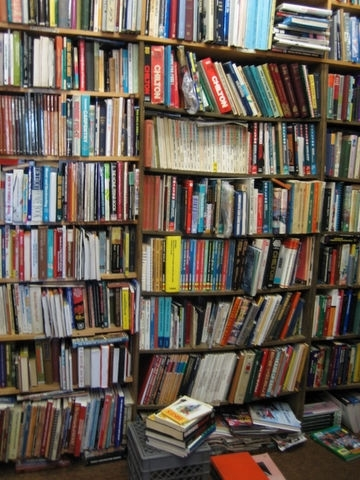

a_dataset/bookstore/bookstore_25_01_flickr.jpg


In [ ]:
from google.colab.patches import cv2_imshow

def showSample(path):
    img = cv2.imread(path)
    cv2_imshow(img) #cv2.imshow() is disabled in Colab, as a substitution, consider using cv2_imshow
    
showSample(data[0])
print(data[0])

In [ ]:
!pip install split-folders
import splitfolders

def split_train_test(data_path,d_output, subcategories,split_ratio):
    splitfolders.ratio(data_path, output=d_output, seed=1337, ratio=split_ratio)




In [ ]:

directory_name= "train_val_test"

data_categories = ['airport_inside', 'artstudio', 'bakery', 'bar', 'bathroom','bedroom','bookstore','bowling','buffet','casino','church_inside','classroom','closet','clothingstore','computerroom']
split_train_test("a_dataset", d_output=directory_name,subcategories=data_categories, split_ratio=(0.7, 0.15,0.15)) #split_ratio=(train,validation,test)


Copying files: 4483 files [00:12, 371.98 files/s]


# **Part-1**

##CNN Models for the Part-1

In [ ]:
class Net1(nn.Module): #Classic Net
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, kernel_size=11, stride=4) #55x55
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) 
      self.conv3 =  nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.conv4 =  nn.Conv2d(64, 64, kernel_size=3, padding=1)
      self.conv5 =  nn.Conv2d(64, 32, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(6*6*32, 600)
      #self.dropout1 = nn.Dropout(0.2)
      self.fc2 = nn.Linear(600, 15)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 3, 2) 
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 3, 2) 
      x = F.relu(self.conv3(x)) 
      x = F.relu(self.conv4(x)) 
      x = F.relu(self.conv5(x)) 
      x = F.max_pool2d(x, 3, 2) 
      x = x.view(-1, 6*6*32)
      x = F.relu(self.fc1(x))
      #x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [ ]:
class Net2(torch.nn.Module): #Residual Net

    def __init__(self):
        super().__init__()
        self.conv4 = nn.Conv2d(3, 8, kernel_size=11, stride=4) #55x55
        self.conv5 = nn.Conv2d(8, 16, kernel_size=3, stride=2) #27*27*16
        self.block1 = torch.nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 16, kernel_size=1, stride=1),
        )
        

        self.fc1 = nn.Linear(13*13*16, 600)
        self.fc2 = nn.Linear(600, 15)

        
    def forward(self, x):
        
        x = F.relu(self.conv4(x)) 
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 3, 2) 

        shortcut = x
        #block1
        x = self.block1(x)
        x = torch.nn.functional.relu(x + shortcut)

        x = x.view(-1, 13*13*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


##Auxiliary Functions

In [ ]:
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

def get_datasets(data_dir,size):
    transform = transforms.Compose([transforms.Resize((size,size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

    train_dataset = datasets.ImageFolder(data_dir + '/train',transform=transform)
    valid_dataset = datasets.ImageFolder(data_dir + '/val',transform=transform)
    test_dataset = datasets.ImageFolder(data_dir + '/test',transform=transform)

    return train_dataset,valid_dataset,test_dataset


def get_loaders(train_dataset,valid_dataset,test_dataset,b_size):
    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

    return train_loader, val_loader, test_loader


train_dataset,valid_dataset,test_dataset =get_datasets(directory_name,227)
#train_loader, val_loader, test_loader = get_loaders(train_dataset,valid_dataset,test_dataset)

In [ ]:

def drawCfMatrix(real_values, pred_values,matrixName):
    cm_array = confusion_matrix(real_values, pred_values)
    df_cm = pd.DataFrame(cm_array, range(15), range(15))
    sn.set(font_scale=1.0)
    ax = plt.axes()
    ax.xaxis.get_offset_text().set_visible(False)
    ax.yaxis.get_offset_text().set_visible(False)
    plt.figure(figsize=(10,10))
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, ax=ax)
    ax.set_title(matrixName)
    plt.savefig(matrixName)
    plt.show()
    plt.clf()


In [ ]:

def visualizeLoaders(data_categories):
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # permute?
        ax.title.set_text(categories[labels[i].item()])
    plt.show()


In [ ]:
def train(model, train_loader, optimizer,criterion):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()     

In [ ]:
def evaluate(model,data_loader, title):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = Variable(data), Variable(target)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            output = model(data)
            
            loss += F.cross_entropy(output, target, reduction='sum').data

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\n ',title, 'Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return loss, 100. * correct / len(data_loader.dataset)

In [ ]:
def get_predictions(model,test_loader):
      model.eval()
      loss = 0
      real_values = []
      predictions = []
      with torch.no_grad():
          for data, target in test_loader:
              data, target = Variable(data), Variable(target)
              if torch.cuda.is_available():
                  data = data.cuda()
                  target = target.cuda()
              
              output = model(data)
              loss += F.cross_entropy(output, target, reduction='sum').data
              pred = output.data.max(1, keepdim=True)[1]
              real_values.append(target)
              predictions.append(pred)
      return np.concatenate(real_values),np.concatenate(predictions) #batch size'lardan dolayı 2d olan arrayi 1d'ye çevirdk

In [ ]:
from torch.autograd import Variable


def tuneModel(i_model,learning_rate):
    model = i_model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
    criterion = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    return model, optimizer, criterion

In [ ]:
def run_epochs(n_epochs, model, train_loader, val_loader, optimizer, criterion):
    val_los = []
    val_acc = []
    for epoch in range(n_epochs):
        train(model, train_loader, optimizer,criterion)
        print("epoch-",epoch)
        avg_loss, accuracy = evaluate(model,val_loader,"Validation")  #(model,data_loader,optimizer criterion, ,title):
        val_los.append(avg_loss)
        val_acc.append(accuracy)
    return val_los,val_acc


In [ ]:
def executeModelByLR(model,num_of_epoch, learn_rate_list,train_loader, val_loader):
    val_los_list = []
    val_acc_list = []
    for lr in learn_rate_list:
        model,optimizer,criterion = tuneModel(model,lr)
        val_los, val_acc = run_epochs(num_of_epoch, model, train_loader, val_loader, optimizer, criterion)
        val_los_list.append(val_los)
        val_acc_list.append(val_acc)
    return val_los_list, val_acc_list

In [ ]:
#şimdi sabit bir lr fakat farklı batch size ile yapacağız
def executeModelByBatchSize(model, num_of_epoch,lr,batch_size_list):
    val_los_list = []
    val_acc_list = []
    for batch_size in batch_size_list:
        train_loader, val_loader, test_loader = get_loaders(train_dataset, valid_dataset, test_dataset, batch_size)
        model,optimizer,criterion =  tuneModel(model,lr)
        val_los, val_acc = run_epochs(num_of_epoch, model, train_loader, val_loader, optimizer, criterion)
        val_los_list.append(val_los)
        val_acc_list.append(val_acc)
    return val_los_list, val_acc_list

In [ ]:
def evaluateByDropOutValues(model, num_of_epoch, dropout_list,learn_rate, train_loader, val_loader):
  val_accuracy_list=[]
  val_loss_list = []
  for dropout in dropout_list:
      model,optimizer,criterion = tuneModel(model,learn_rate)
      model.fc1 = nn.Sequential(nn.Linear(model.fc1.in_features, model.fc2.in_features), nn.Dropout())
      model.fc1[1].p = dropout #tune new dropout value(p)
      val_los, val_acc = run_epochs(num_of_epoch, model, train_loader, val_loader, optimizer, criterion)
      val_loss_list.append(val_los)
      val_accuracy_list.append(val_acc)
  return val_accuracy_list, val_loss_list

In [ ]:
def drawGraph(param_type_list,los_list, acc_list,parameterType):
    fig, axes = plt.subplots(figsize=(20, 8), ncols=2)
    ax = axes[0]
    i = 0
    for l in los_list:
        ax.plot(l, label= parameterType+ str(param_type_list[i]))
        i = i+1
    ax.title.set_text("Loss")
    ax.legend()


    ax = axes[1]
    i = 0
    for acc in acc_list:
        ax.plot(acc, label=parameterType + str(param_type_list[i]))
        i = i+1
    ax.title.set_text('Accuracy')
    ax.legend()

    fig.savefig('graph.jpg') #bunun ismi de değişecek
    plt.show()





## Results for First Model

### Learning Rates

In [ ]:
train_loader, val_loader, test_loader = get_loaders(train_dataset, valid_dataset, test_dataset, 256)

lr_list = [0.1,0.01,0.001,0.0001]
val_los_list, val_acc_list = executeModelByLR(Net1(),30, lr_list,train_loader, val_loader)

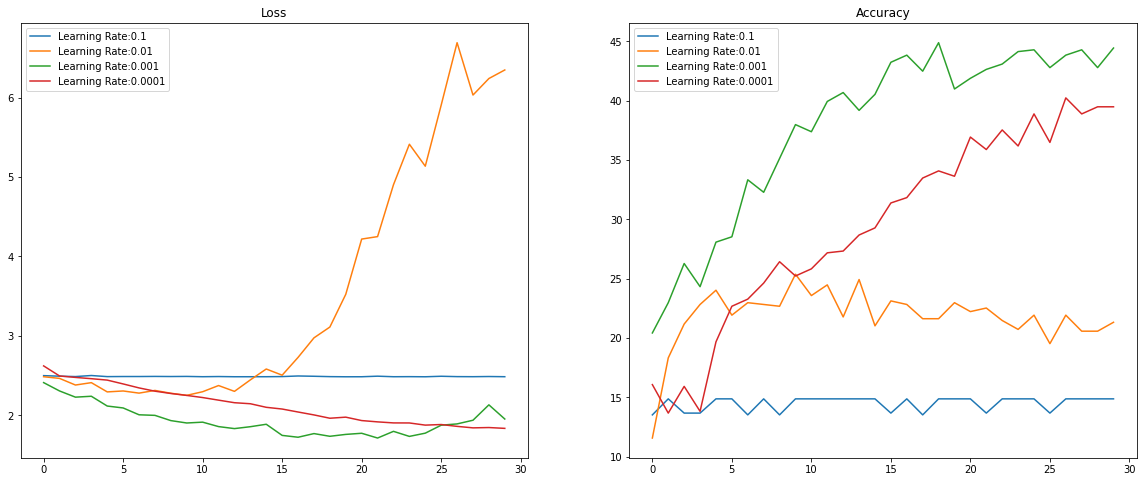

In [ ]:
drawGraph(lr_list,val_los_list,val_acc_list,"Learning Rate:") #draw graph for learning rates

###Batch Size

In [ ]:
lr = 0.001 #gave best results
batch_size_l = [32,64,128,256]
b_val_los_list, b_val_acc_list = executeModelByBatchSize(Net1(), 30, lr, batch_size_l)

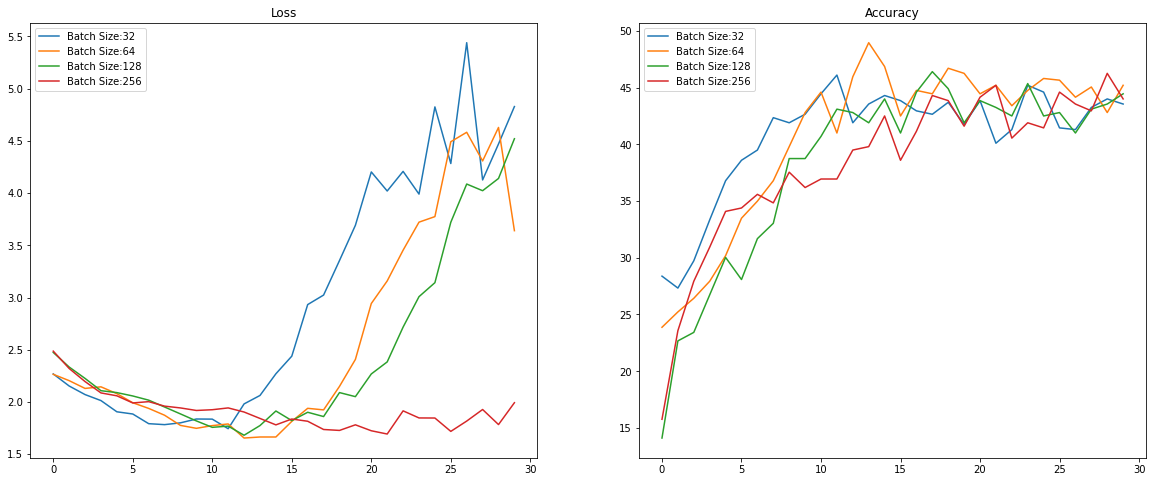

In [ ]:
drawGraph(batch_size_l,b_val_los_list,b_val_acc_list,"Batch Size:") #draw graph for batch sizes

### Dropout for First Model

In [ ]:
#Test the model with different dropout values
train_loader, val_loader, test_loader = get_loaders(train_dataset, valid_dataset, test_dataset,256)

drop_list =[0.1, 0.2, 0.4, 0.8]
val_accuracy_list, val_loss_list = evaluateByDropOutValues(Net1(), 10, drop_list,0.001, train_loader, val_loader)

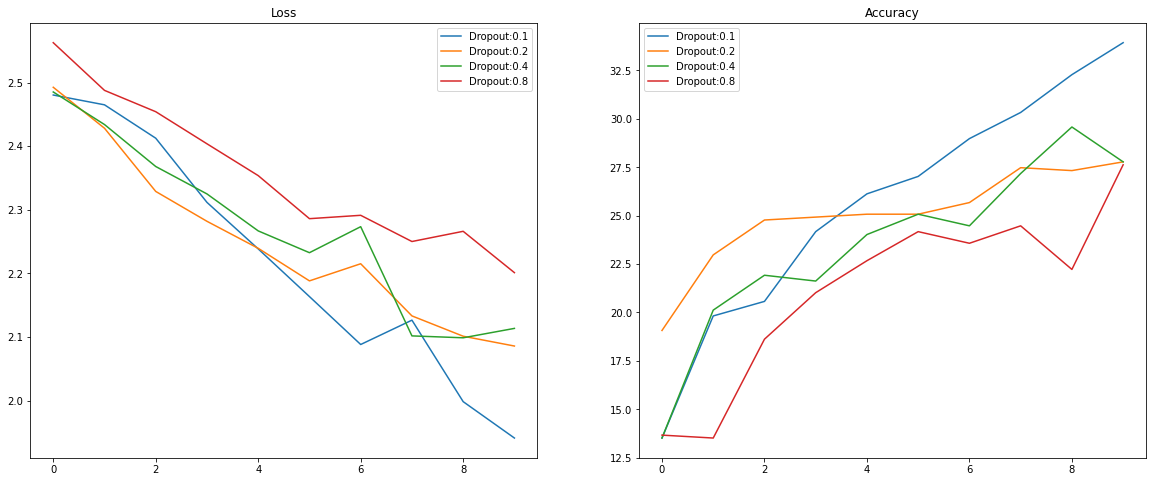

In [ ]:
drawGraph(drop_list,val_loss_list, val_accuracy_list,"Dropout:") #draw graph for batch sizes

###Confusion Matrix

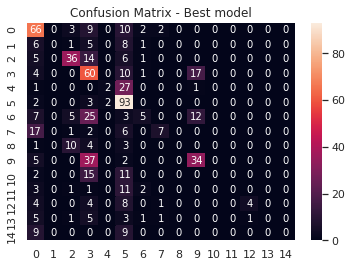

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#CONFUSION MATRIX OF BEST MODEL ()
model.fc1[1].p = 0.4
real_labels, pred_values = get_predictions(model,test_loader)

drawCfMatrix(real_labels, pred_values, "Confusion Matrix - Best model")

## Results for Second Model (Residual)

###Learning Rates

In [ ]:
train_loader, val_loader, test_loader = get_loaders(train_dataset, valid_dataset, test_dataset,256)

In [ ]:
learn_list = [ 0.005 ,0.001, 0.0005,0.0001]
res_val_los_list, res_val_acc_list = executeModelByLR(Net2(),30, lr_list,train_loader, val_loader)

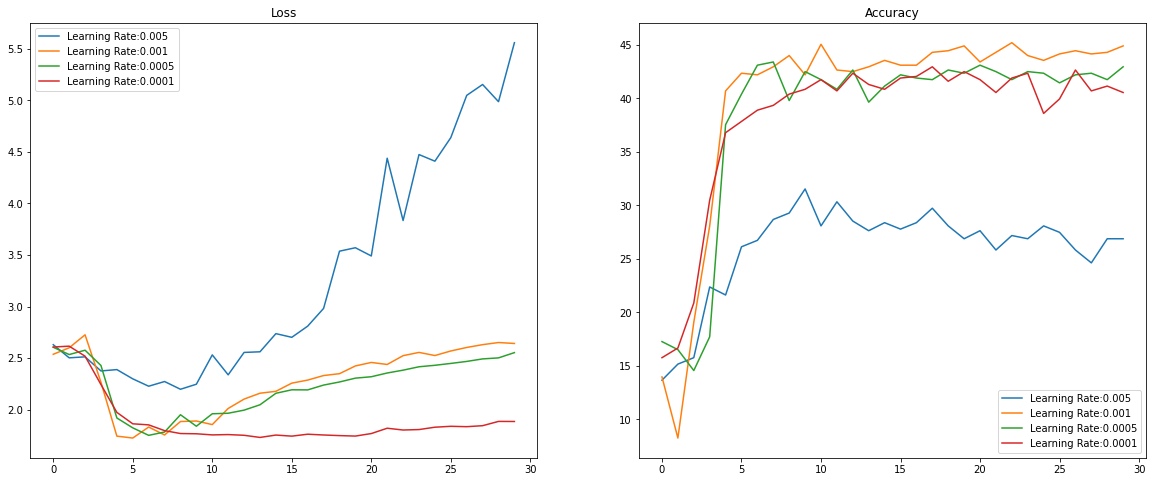

In [ ]:
drawGraph(learn_list,res_val_los_list, res_val_acc_list,"Learning Rate:") #draw graph for learning rates

###Batch Size

In [ ]:
lr = 0.001 #gave best results for residual connected CNN
batch_size_l = [32,64,128,256]
res_batch_val_los_list, res_batch_val_acc_list = executeModelByBatchSize(Net2(), 30, lr, batch_size_l)

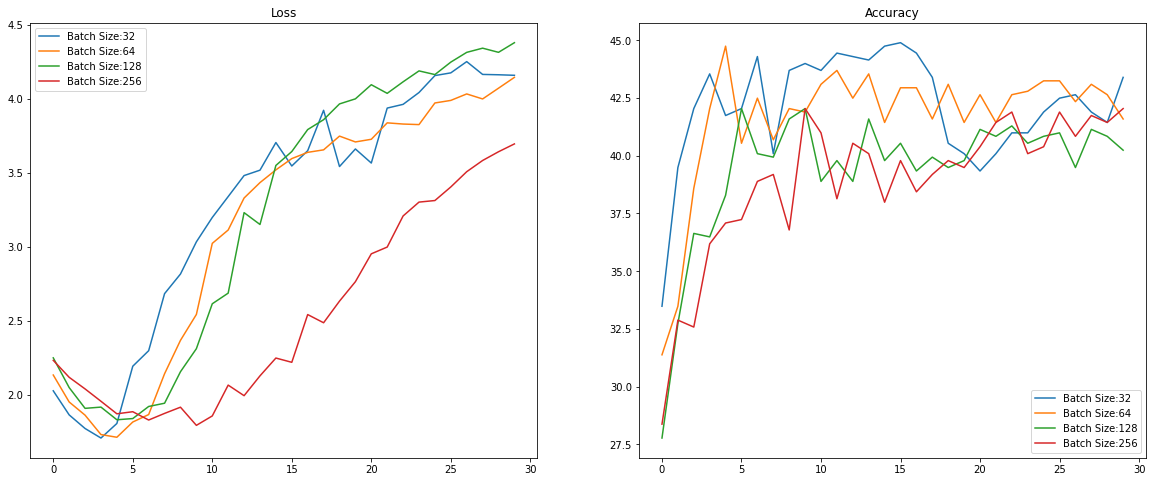

In [ ]:
drawGraph(batch_size_l,res_batch_val_los_list, res_batch_val_acc_list,"Batch Size:") #draw graph for batch sizes

###Dropout for the best model

Best parameters:
LR: 0.001
Batch Size: 256

In [ ]:
#Test the model with different dropout values
train_loader, val_loader, test_loader = get_loaders(train_dataset, valid_dataset, test_dataset,256)

drop_list =[0.1, 0.2, 0.4, 0.8]

val_accuracy_list, val_loss_list = evaluateByDropOutValues(Net2(), 10, drop_list,0.001, train_loader, val_loader)

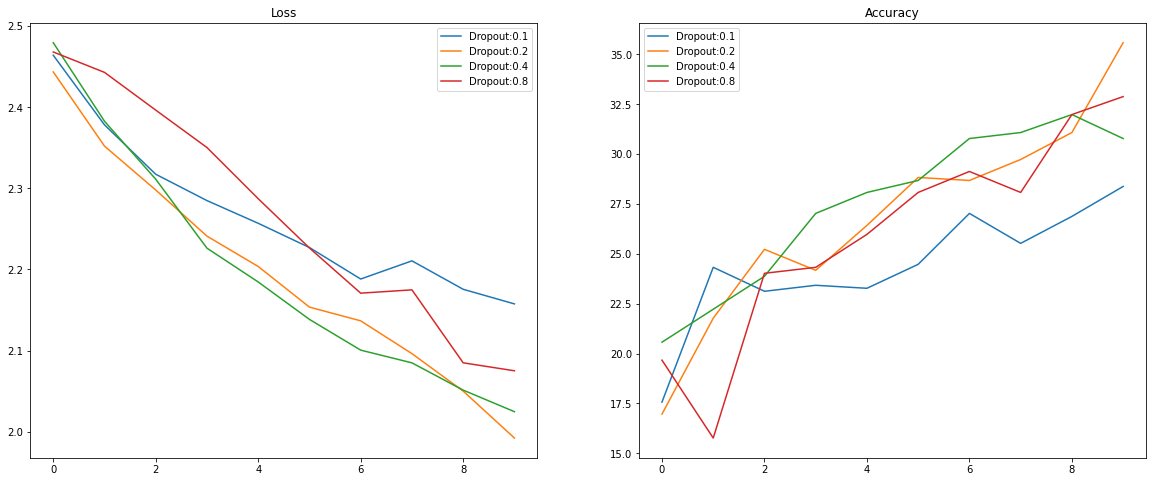

In [ ]:
drawGraph(drop_list,val_loss_list, val_accuracy_list,"Dropout:") #draw graph for batch sizes

###Confusion Matrix of the Best Model

In [ ]:
train_loader, val_loader, test_loader = get_loaders(train_dataset, valid_dataset, test_dataset,256)
best_model,best_optimizer,best_criterion = tuneModel(Net2(),0.001)
run_epochs(30, best_model, train_loader, val_loader, best_optimizer, best_criterion)

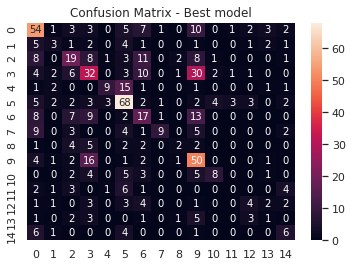

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
real_labels, pred_values = get_predictions(best_model,test_loader)

drawCfMatrix(real_labels, pred_values, "Confusion Matrix - Best model")

# Part-2: Transfer Learning 

## Auxiliary Functions

In [ ]:
def run_res_epochs(n_epochs, model, train_loader, val_loader,test_loader, optimizer, criterion):
    val_los = []
    val_acc = []
    test_los = []
    test_acc = []
    for epoch in range(n_epochs):
        train(model, train_loader, optimizer,criterion)
        print("epoch-",epoch)

        avg_loss, accuracy = evaluate(model,val_loader,"Validation") 
        val_los.append(avg_loss)
        val_acc.append(accuracy)
        
        avg_test_loss, test_accuracy = evaluate(model,test_loader,"Test") 
        test_los.append(avg_test_loss)
        test_acc.append(test_accuracy)

    return val_los,val_acc,test_los,test_acc

In [ ]:
def freeze_all_layers(model):
    for param in model.parameters(): #freezes the all weights
        param.requires_grad = False
    
    print('All layers have been frozen.')
    return model


In [ ]:
def unfroze_layers(model,unfrozen_layers):
    for name, child in model.named_children():
        if name in unfrozen_layers:
            for param in child.parameters():
                param.requires_grad = True
            print(name + ' has been unfrozen.')

        else:
            for param in child.parameters():
                param.requires_grad = False
    return model

##First Model: Only FC

In [ ]:
#Since ResNet use 224x224x3 images, we should resize the images to 224x224
res_train_dataset, res_valid_dataset, res_test_dataset = get_datasets(directory_name,224)
train_loader, val_loader, test_loader = get_loaders(res_train_dataset, res_valid_dataset, res_test_dataset, 256)

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
for name, child in resnet18.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
num_ftrs = resnet18.fc.in_features # last layer inputs
resnet18.fc = nn.Linear(num_ftrs, 15) # Modifying the last layer accordng to our need
print(resnet18.fc)



Linear(in_features=512, out_features=15, bias=True)


In [ ]:
resnet18 = freeze_all_layers(resnet18) #froze all layers of resnet

All layers have been frozen.


In [ ]:
resnet_fc = unfroze_layers(resnet18, ['fc']) #unfroze the last fc layer

fc has been unfrozen.


In [ ]:
resnet_fc.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, resnet_fc.parameters()), lr=0.001, momentum=0.9) #only optimize the layers that are not frozened.

if torch.cuda.is_available():
    resnet_fc = resnet_fc.cuda()
    criterion = criterion.cuda()

###Results for the First ResNet Model

In [ ]:
#run epochs
fc_val_los_list, fc_val_acc_list, fc_test_los_list, fc_test_acc_list = run_res_epochs(6, resnet_fc, train_loader, val_loader, test_loader, optimizer, criterion)

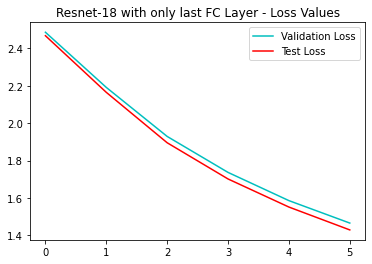

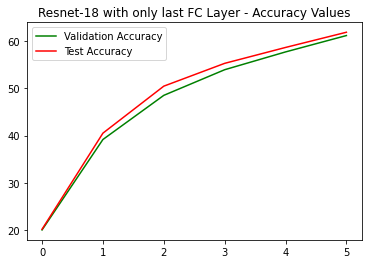

In [ ]:
plt.plot(fc_val_los_list,color='c',label="Validation Loss")
plt.plot(fc_test_los_list,color='r',label="Test Loss")
plt.title("Resnet-18 with only last FC Layer - Loss Values")
plt.legend()
plt.show()

plt.plot(fc_val_acc_list,color='g',label="Validation Accuracy")
plt.plot(fc_test_acc_list,color='r',label="Test Accuracy")
plt.title("Resnet-18 with only last FC Layer - Accuracy Values")
plt.legend()
plt.show()

##Second Model: Only FC + Last Conv

In [ ]:
resnet_cv = models.resnet18(pretrained=True)

num_ftrs = resnet_cv.fc.in_features # last layer inputs
resnet_cv.fc = nn.Linear(num_ftrs, 15) # Modifying the last layer accordng to our need



Linear(in_features=512, out_features=15, bias=True)


In [ ]:
resnet_cv = freeze_all_layers(resnet_cv)
resnet_cv = unfroze_layers(resnet_cv, ['fc']) #unfroze the fc layer
resnet_cv.layer4[1].conv2.weight.requires_grad = True #unfroze the last conv layer

In [ ]:
resnet_cv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, resnet_cv.parameters()), lr=0.001, momentum=0.9) #only optimize the layers that are not frozened.

if torch.cuda.is_available():
    resnet_cv = resnet_cv.cuda()
    criterion = criterion.cuda()



###Results for the Second ResNet Model

In [ ]:
conv_val_los_list, conv_val_acc_list, conv_test_los_list, conv_test_acc_list = run_res_epochs(6, resnet_cv, train_loader, val_loader,test_loader, optimizer, criterion)

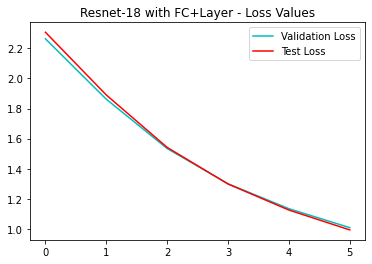

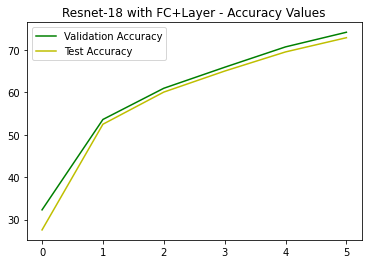

In [ ]:
plt.plot(conv_val_los_list,color='c',label="Validation Loss")
plt.plot(conv_test_los_list,color='r',label="Test Loss")
plt.title("Resnet-18 with FC+Layer - Loss Values")
plt.legend()
plt.show()

plt.plot(conv_val_acc_list,color='g',label="Validation Accuracy")
plt.plot(conv_test_acc_list,color='y',label="Test Accuracy")
plt.title("Resnet-18 with FC+Layer - Accuracy Values")
plt.legend()
plt.show()

##Comparison of the ResNet Models

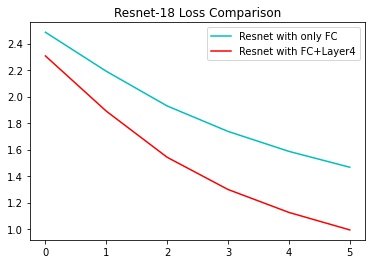

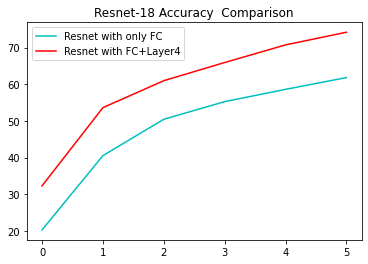

In [ ]:
plt.plot(fc_val_los_list,color='c',label="Resnet with only FC")
plt.plot(conv_test_los_list,color='r',label="Resnet with FC+Last Conv Layer")
plt.title("Resnet-18 Loss Comparison")
plt.legend()
plt.show()

plt.plot(fc_test_acc_list,color='c',label="Resnet with only FC")
plt.plot(conv_val_acc_list,color='r',label="Resnet with FC+Last Conv Layer")
plt.title("Resnet-18 Accuracy  Comparison")
plt.legend()
plt.show()

##Confusion Matrix of the Best Model


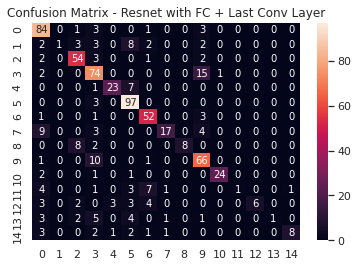

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#CONFUSION MATRIX OF BEST MODEL (Resnet with FC Layer and Layer 4)
real_labels, pred_values = get_predictions(resnet_cv,test_loader)

drawCfMatrix(real_labels, pred_values, "Confusion Matrix - Resnet with FC + Last Conv Layer")